In [1]:
from load_modules import *
import colorspacious
from datetime import datetime
from time import time

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        print("Device:", device)
else:
    print("No GPU devices found.")

# Set GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
    except RuntimeError as e:
        print(e)

# Test for GPU device name
name = tf.test.gpu_device_name()
if name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(name))

# Print the number of available GPUs
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
# with tf.device('/device:GPU:0'):
np.random.seed(42)
#load csv into 
# data_path = r"C:\Users\joeli\OneDrive\Documents\GitHub\EncoderDecoder\JJ_LUT.csv"
headers = "Cm,Ch,Bm,Bh,T,sR,sG,sB,L,A,B"

# lut_path = r"C:\Users\joeli\OneDrive\Documents\GitHub\PhysicalModels\LargeMCLUT.csv"

# lut_path2 = r"C:\Users\joeli\Dropbox\MC_LUTs\expanded_range60k.csv"
lut_path1 = r"C:\Users\joeli\Dropbox\MC_LUTs\two_hundredkLUT.csv"
# lut_path2 = r"C:\Users\joeli\Dropbox\MC_LUTs\last_try.csv"
lut_path2 = r"C:\Users\joeli\Dropbox\MC_LUTs\uniform100k.csv"

df1 = pd.read_csv(lut_path1, sep=",", header=None, names=headers.split(","))
#drop header
df1 = df1[1:]
df2 = pd.read_csv(lut_path2, sep=",", header=None, names=headers.split(","))
#drop header
# df2 = df2[1:]

# df3 = pd.read_csv(lut_path3, sep=",", header=None, names=headers.split(","))
# df3 = df3[1:]
df = pd.concat([df2])
df = df.drop_duplicates()
#print length of df
print(f"length of df {len(df)}")
df['T'] = pd.to_numeric(df['T'], errors='coerce')
df['Cm'] = pd.to_numeric(df['Cm'], errors='coerce')
df['Ch'] = pd.to_numeric(df['Ch'], errors='coerce')
df['Bh'] = pd.to_numeric(df['Bh'], errors='coerce')
df['Bm'] = pd.to_numeric(df['Bm'], errors='coerce')
# Drop rows where 'T' > 0.26
# df = df[df['T'] <= 0.3]
#drop cm < 0.001 and cm > 0.5
# df = df[df['Cm'] >= 0.001]
# df = df[df['Ch'] >= 0.001]

#drop rows with Bh > 0.5
# df = df[df['Bh'] >= 0.25]


df.drop(df.index[0], inplace=True)
print(f"length of df {len(df)}")
# Filter out non-numeric rows
def is_numeric(string):
    try:
        float(string)
        return True
    except ValueError:
        return False
#save as new csv
name = "donner_lut.csv"
#write header

df.to_csv(name, index=False)
x = df[['sR', 'sG', 'sB']].applymap(is_numeric)

x = df[x.all(axis=1)][['sR', 'sG', 'sB']].to_numpy(dtype='float32')
#convert from sRGB255 to sRGB1

y = df[['Cm', 'Ch', 'Bm', 'Bh', 'T']].applymap(is_numeric)
y = df[y.all(axis=1)][['Cm', 'Ch', 'Bm', 'Bh', 'T']].to_numpy(dtype='float32')

df.head()

#train nn on x,y
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42, shuffle=True)
#remove any header values
x_train = x_train[1:]
x_test = x_test[1:]
y_train = y_train[1:]
y_test = y_test[1:]

#numpy arrays
x_train = np.asarray(x_train).reshape(-1,3).astype('float32')
x_test = np.asarray(x_test).reshape(-1,3).astype('float32')
print(f"length of df {len(df)}")
print(f"bef norm x_train[0] {x_train[0]}")

#normalize
x_train = x_train/255.0
x_test = x_test/255.0
print(f"aft norm x_train[0] {x_train[0]}")

print(f"length of x_train {len(x_train)}")
print(f"length of x_test {len(x_test)}")
print(f"length of y_train {len(y_train)}")
print(f"length of y_test {len(y_test)}")
df.head()
print(f"length of df {len(df)}")
#print random 3 rows
#print unique values of Cm,Ch,Bm,Bh,T
# print(f"unique Cm {df['Cm'].unique()}")
# print(f"unique Ch {df['Ch'].unique()}")
# print(f"unique Bm {df['Bm'].unique()}")
# print(f"unique Bh {df['Bh'].unique()}")
# print(f"unique T {df['T'].unique()}")
#as sorted lists
C_m = sorted(df['Cm'].unique())
C_h = sorted(df['Ch'].unique())
B_m = sorted(df['Bm'].unique())
B_h = sorted(df['Bh'].unique())
T = sorted(df['T'].unique())
print(f"Cm = {C_m}")
print(f"Ch = {C_h}")
print(f"Bm = {B_m}")
print(f"Bh = {B_h}")
print(f"T = {T}")
#min max for each
min_vals = [min(C_m), min(C_h), min(B_m), min(B_h), min(T)]
max_vals = [max(C_m), max(C_h), max(B_m), max(B_h), max(T)]
print(f"upper bounds = {max_vals}")
print(f"lower bounds = {min_vals}")
#integer arrays for sR,sG,sB 0 to 255
# Assuming df is your DataFrame and it has columns 'sR', 'sG', 'sB'
df[['sR', 'sG', 'sB']] = df[['sR', 'sG', 'sB']].astype(float)
df[['sR', 'sG', 'sB']] = df[['sR', 'sG', 'sB']].applymap(np.round)

# Add a 'count' column that counts the number of identical RGB values
df['count'] = df.groupby(['sR', 'sG', 'sB'])['sR'].transform('count')
print(f"number of repeated RGB values {len(df[df['count'] > 1])}")

C:\Users\joeli\AppData\Local\Temp\ipykernel_44448\1475438521.py:14: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(lut_path1, sep=",", header=None, names=headers.split(","))
C:\Users\joeli\AppData\Local\Temp\ipykernel_44448\1475438521.py:17: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(lut_path2, sep=",", header=None, names=headers.split(","))


length of df 100001
length of df 100000
length of df 100000
bef norm x_train[0] [84.051 32.715 28.55 ]
aft norm x_train[0] [0.32961178 0.12829413 0.11196078]
length of x_train 89999
length of x_test 9999
length of y_train 89999
length of y_test 9999
length of df 100000
Cm = [0.001, 0.008, 0.027, 0.0639, 0.1249, 0.2158, 0.3427, 0.5115, 0.7283, 0.999]
Ch = [0.001, 0.0052, 0.0169, 0.0417, 0.087, 0.162, 0.2775, 0.4458, 0.681, 0.999]
Bm = [0.0, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889, 1.0]
Bh = [0.0, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889, 1.0]
T = [0.01, 0.0367, 0.0633, 0.09, 0.1167, 0.1433, 0.17, 0.1967, 0.2233, 0.25]
upper bounds = [0.999, 0.999, 1.0, 1.0, 0.25]
lower bounds = [0.001, 0.001, 0.0, 0.0, 0.01]
number of repeated RGB values 66498


In [ ]:
np.random.seed(7)
BATCH_SIZE = 64
def decoder():
    input = Input(shape=(5,), name="decoder_input")
    x = Dense(80, activation='relu', name="decoder_dense_1")(input)
    x = Dense(80, activation='relu', name="decoder_dense_2")(x)
    x = Dense(80, activation='relu', name="decoder_dense_3")(x)
    #leaky relu
    
    out = Dense(3, name="encoder_output")(x)
    model = Model(inputs=input, outputs=out, name='decoder')
    return model
def encoder():
    input = Input(shape=(3,),name="encoder_input")
    x = Dense(80, activation='relu', name="encoder_dense_1")(input)
    x = Dense(80, activation='relu', name="encoder_dense_2")(x)
    x = Dense(80, activation='relu', name="encoder_dense_3")(x)
    out = Dense(5, name="decoder_output")(x)
    model = Model(inputs=input, outputs=out, name = 'encoder')
    return model
def autoencoder(encoder, decoder):
    input_end_to_end = Input(shape=(3,))
    l1 = encoder(input_end_to_end)
    l2 = decoder(l1)
    input_list = [encoder.input, decoder.input, input_end_to_end]
    output_list = [encoder.output, decoder.output, l2]
    model = Model(inputs=input_list, outputs=output_list, name = 'autoencoder')
    return model
encoder = encoder()
decoder = decoder()
autoencoder = autoencoder(encoder, decoder)
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())
albedo_pred_values = []
albedo_true_values = []
def albedo_loss(y_true, y_pred):
    #l1 norm
    l1_norm = K.sum(K.abs(y_pred - y_true), axis=-1)
    albedo_pred_values.append(y_pred)
    albedo_true_values.append(y_true)
    return l1_norm
upper_bounds = [0.5, 0.32, 0.9, 0.9, 0.25]
lower_bounds = [0.01, 0.001, 0.2, 0.6, 0.05]
# upper_bounds = [0.8, 0.5, 1.0, 1.0, 0.25]
# lower_bounds = [0.003, 0.001, 0.0, 0.0, 0.01]
def parameter_loss(y_true, y_pred):
    #l2 norm
    l2_norm = K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

    lower_bound_mask = tf.math.less(y_pred, lower_bounds)
    upper_bound_mask = tf.math.greater(y_pred, upper_bounds)
    out_of_range_mask = tf.logical_or(lower_bound_mask, upper_bound_mask)
    out_of_range_mask = tf.cast(out_of_range_mask, tf.float32)
    # # Apply a penalty for out of range values)
    out_of_range_penalty = tf.reduce_sum(tf.cast(out_of_range_mask, tf.float32))
    # negative_penalty = tf.reduce_sum(tf.cast(tf.math.less(y_pred, 0.0), tf.float32)) #penalty for negative values ie ypred [-0.01,0,0,0,0] = tf.reduce_sum(tf.cast(tf.math.less(y_pred, 0.0), tf.float32))/5.0 = 0.2
    return l2_norm + out_of_range_penalty
def end_to_end_loss(y_true, y_pred):
    #l1 norm
    l1_norm = K.sum(K.abs(y_pred - y_true), axis=-1)
    return l1_norm


# # Compile the autoencoder with the custom loss function and optimizer
# autoencoder.compile(optimizer='adam', loss=[parameter_loss, albedo_loss, end_to_end_loss], loss_weights=[.3,.1, .6])
# autoencoder.compile(optimizer='adam', loss=[parameter_loss, albedo_loss, end_to_end_loss], loss_weights=[.6,.1,.3])
# 0.2, 0.1, 0.7
autoencoder.compile(optimizer='adam', loss=[parameter_loss, albedo_loss, end_to_end_loss], loss_weights=[.1,.1,.8])


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 3)]               0         
_________________________________________________________________
encoder_dense_1 (Dense)      (None, 80)                320       
_________________________________________________________________
encoder_dense_2 (Dense)      (None, 80)                6480      
_________________________________________________________________
encoder_dense_3 (Dense)      (None, 80)                6480      
_________________________________________________________________
decoder_output (Dense)       (None, 5)                 405       
Total params: 13,685
Trainable params: 13,685
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder"
_________________________________________________________________
Layer (type)                 Outp

In [ ]:
checkpoint = ModelCheckpoint(r"C:\Users\joeli\OneDrive\Documents\GitHub\AutoEncoder_Integrated\autoencoder_best.h5py", monitor='loss', verbose=0,
    save_best_only=True, mode='auto', period=200)
adjust_lr = ReduceLROnPlateau(monitor='loss', factor=0.01, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-8, lr=1e-3)
# Define the Keras TensorBoard callback.

logdir=r"C:\Users\joeli\OneDrive\Documents\GitHub\AutoEncoder_Integrated\tensorboard_log_dir"
# tensorboard_callback = tf.keras.callbacks.TensorBoard(filepath=logdir, save_weights_only = True,save_freq = 100,verbose = 1)
print_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"epoch: {epoch} , {logs}") if epoch % 25 == 0 else None)

callbacks = [
    checkpoint,
    adjust_lr,
    print_callback
]
with tf.device('/device:GPU:0') as device:
    #show device name
    print(device)
    #ae_in: enc_in, dec_in, end_to_end_in
    x = [x_train, y_train,x_train]
     #ae_out: enc_out, dec_out, end_to_end_out
    x_val = [x_test, y_test,x_test]
    #outputs: encoder, decoder, autoencoder
    y = [y_train,x_train,x_train]
    y_val = [y_test,x_test,x_test]
    # print(tf.config.list_physical_devices('GPU'))
    #adjust how often to print loss

    autoencoder.fit(x,y, epochs=200, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_val, y_val), callbacks=callbacks,verbose=0)

       

None
epoch: 0 , {'loss': 13.049241065979004, 'decoder_output_loss': 130.01036071777344, 'encoder_output_loss': 0.12950676679611206, 'decoder_loss': 0.04407023638486862, 'val_loss': 13.521394729614258, 'val_decoder_output_loss': 134.97775268554688, 'val_encoder_output_loss': 0.06751357764005661, 'val_decoder_loss': 0.021081700921058655, 'lr': 0.001}
epoch: 25 , {'loss': 10.690773010253906, 'decoder_output_loss': 106.81608581542969, 'encoder_output_loss': 0.021336309611797333, 'decoder_loss': 0.008788492530584335, 'val_loss': 10.66218376159668, 'val_decoder_output_loss': 106.5476303100586, 'val_encoder_output_loss': 0.020492158830165863, 'val_decoder_loss': 0.006714009679853916, 'lr': 0.001}
epoch: 50 , {'loss': 10.556387901306152, 'decoder_output_loss': 105.53504943847656, 'encoder_output_loss': 0.015107548795640469, 'decoder_loss': 0.0017091810004785657, 'val_loss': 10.601625442504883, 'val_decoder_output_loss': 105.9869613647461, 'val_encoder_output_loss': 0.015445142053067684, 'val_d

In [ ]:
import os


directory_path = r"C:\Users\joeli\OneDrive\Documents\GitHub\AutoEncoder_Integrated\ae_118_mask_bs2048"
# Save the models as .pb files
tf.saved_model.save(encoder, os.path.join(directory_path, 'encoder_pb'))
tf.saved_model.save(decoder, os.path.join(directory_path, 'decoder_pb'))
tf.saved_model.save(autoencoder, os.path.join(directory_path, 'autoencoder_pb'))
# Saving the models as .h5 files
# encoder_path = directory_path + 'encoder.h5'
# decoder_path = directory_path + 'decoder.h5'
# autoencoder_path = directory_path + 'ae.h5'
# encoder.save(encoder_path)
# decoder.save(decoder_path)
# autoencoder.save(autoencoder_path)

INFO:tensorflow:Assets written to: C:\Users\joeli\OneDrive\Documents\GitHub\AutoEncoder_Integrated\ae_118_mask_bs2048\encoder_pb\assets
INFO:tensorflow:Assets written to: C:\Users\joeli\OneDrive\Documents\GitHub\AutoEncoder_Integrated\ae_118_mask_bs2048\decoder_pb\assets
INFO:tensorflow:Assets written to: C:\Users\joeli\OneDrive\Documents\GitHub\AutoEncoder_Integrated\ae_118_mask_bs2048\autoencoder_pb\assets


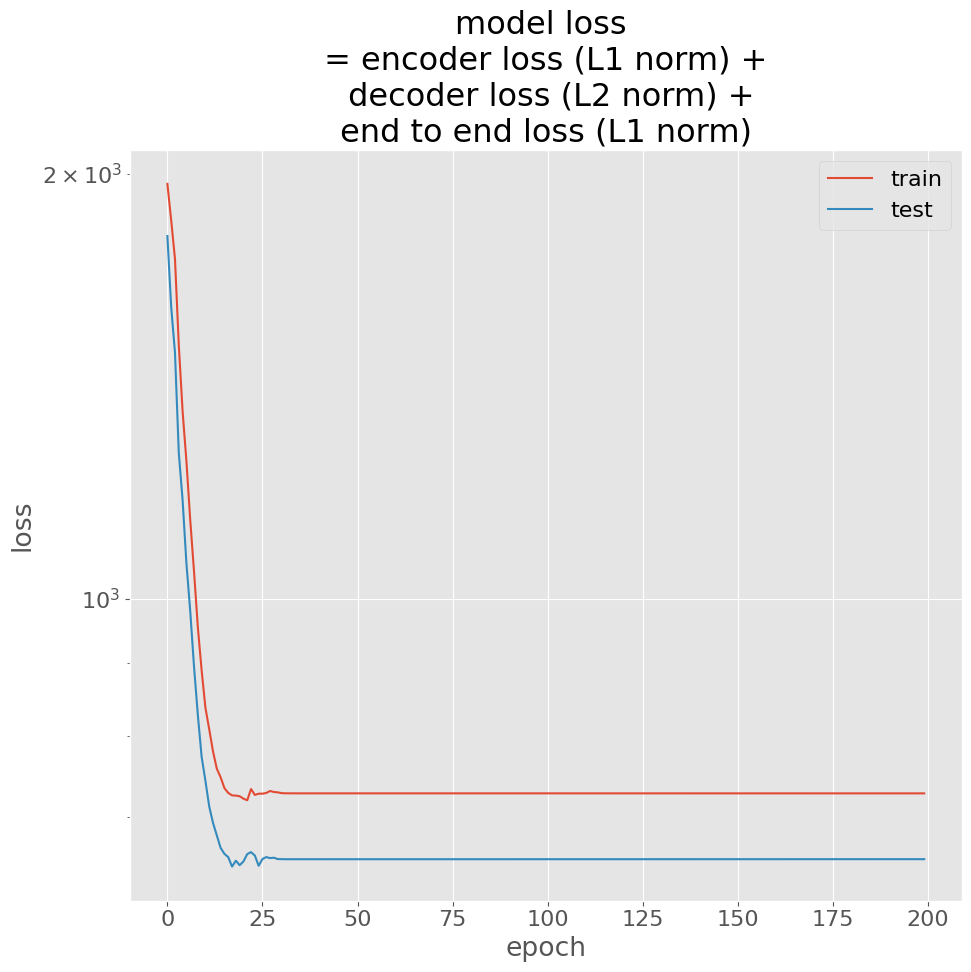

In [ ]:
# # Plot the loss function
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
#add tick labels
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
#ggplot style
plt.style.use('ggplot')
plt.figure(figsize=(10,10))
#fontsize 16
plt.rcParams.update({'font.size': 16})
plt.plot(autoencoder.history.history['loss']) 
plt.plot(autoencoder.history.history['val_loss'])
plt.title('model loss \n = encoder loss (L1 norm) + \n decoder loss (L2 norm) +\n end to end loss (L1 norm) ')
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.yticks
# plt.xlim(-1,50)
plt.tight_layout()
plt.legend(['train', 'test'], loc='upper right')
#show tick labels
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.show()




In [ ]:
# import numpy as np
# import os
# import time
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# from PIL import Image

# CMAP_SPECULAR = plt.get_cmap('viridis')

# def encode(img):
#     image = np.asarray(img).reshape(-1,3).astype('float32')/255.0
#     pred_maps = encoder.predict_on_batch(image)
#     return pred_maps

# def decode(encoded):
#     recovered = decoder.predict_on_batch(encoded)
#     recovered = np.clip(recovered, 0, 1)
#     return recovered
# def calculate_deltaE(original, recovered):  # assuming this function is defined
#     width = original.shape[0]
#     height = original.shape[1]
#     print(width, height)
#     # Convert the images to the CAM02-UCS color space and calculate the delta E loss
#     original_lab = colorspacious.cspace_convert(np.array(original), 'sRGB1', 'CAM02-UCS')
#     recovered_lab = colorspacious.cspace_convert(np.array(recovered), 'sRGB1', 'CAM02-UCS')
#     delta_e = np.sqrt(np.sum((original_lab - recovered_lab)**2, axis=2)).reshape(width, height)
#     print(delta_e.shape)
#     if delta_e.shape[0] != width or delta_e.shape[1] != height:
#         delta_e = delta_e.reshape(width, height)
#     # Plot the delta E loss in the third subplot
#     return delta_e
# def process_single_albedo_image(image_path):
#     if not os.path.exists(image_path):
#         print(f"Path {image_path} does not exist.")
#         return

#     top_path = "LargeLUT_2k"
#     if not os.path.exists(top_path):
#         os.mkdir(top_path)
#         print(f"created {top_path}")

#     albedo_path = os.path.dirname(image_path)
#     recovered_path = os.path.join(albedo_path, "recovered")
#     original_path = os.path.join(albedo_path, "original")
#     parameter_path = os.path.join(albedo_path, "parameters")
#     result_path = os.path.join(albedo_path, "results")
#     top_path = os.path.join(albedo_path, top_path)

#     for path in [recovered_path, original_path, parameter_path, result_path]:
#         if not os.path.exists(path):
#             os.mkdir(path)
#             print(f"created {path}")

#     mpl.rcParams['axes.grid'] = False

#     file_name = os.path.basename(image_path)
#     file_name = "Skin Sample"
#     print(file_name)
#     Image.MAX_IMAGE_PIXELS = None
#     image = Image.open(image_path)
#     image = image.resize((2046,2046))
#     image = image.convert('RGB')
#     height, width = image.size
#     print(width, height)

#     image = np.asarray(image)
#     print(image.shape)
#     dim = (width, height)
#     encode_start = time.time()
#     pred_maps = encode(image)
#     #melanin
#     melanin = pred_maps[:,0].reshape((width, height))
#     # #increase melanin 
#     melanin = melanin
#     # pred_maps[:,0] = melanin.reshape((width*height))
#     # #hemoglobin
#     hemoglobin = pred_maps[:,1].reshape((width, height))
#     # #Bm
#     # blend_mel = pred_maps[:,2].reshape((width, height))
#     # blend_mel = blend_mel * 1.2+0.1
#     encode_end = time.time()
#     encode_time = encode_end - encode_start
#     print(f"encode time: {encode_time}")
#     decode_start = time.time()
#     recovered = decode(pred_maps)
#     decode_end = time.time()
#     decode_time = decode_end - decode_start
#     print(f"decode time: {decode_time}")
#     recovered = np.reshape(recovered, (width, height, 3))
#     print(recovered.shape)
#     #



#     return image, pred_maps, recovered, melanin, hemoglobin
#     # ... (The rest of the code remains unchanged) ...

# if __name__ == "__main__":
#     image_path = r"C:\Users\joeli\Dropbox\SkinSample.png"
#     image, pred_maps, recovered,melanin, hemoglobin = process_single_albedo_image(image_path)
#     #plot original and recovered side by side set fig size bigger than default
#     #remove ticks

#     plt.figure(figsize=(9,5))
#     plt.subplot(1,2,1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.imshow(image)
#     # plt.title("Original")
#     plt.subplot(1,2,2)
#     # plt.title("Recovered")
#     plt.imshow(recovered)
#     plt.xticks([])
#     plt.yticks([])
#     #remove white space
#     plt.tight_layout()
#     plt.show()
#     plt.imsave(r"C:\Users\joeli\Dropbox\SkinSampleOriginalRecovered.png", recovered, dpi=2000)
#     #plot the maps
#     plt.figure(figsize=(9,5))
#     plt.subplot(1,2,1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.imshow(melanin, cmap='viridis')
#     # plt.title("Melanin")
#     plt.subplot(1,2,2)
#     plt.xticks([])
#     plt.yticks([])
#     plt.imshow(hemoglobin, cmap='viridis')
#     # plt.title("Hemoglobin")
#     #remove white space
#     plt.tight_layout()
#     plt.show()



#     #save recovered image
#     plt.imsave(r"C:\Users\joeli\Dropbox\SkinSampleMelHem.png", recovered, dpi=2000)


In [ ]:
# #remove ticks
# plt.xticks([])
# plt.yticks([])
# def encode(img):
#     image = np.asarray(img).reshape(-1,3).astype('float32')/255.0
#     # pred_maps = encoder.predict(image)
#     pred_maps = encoder.predict_on_batch(image)
#     print(f"shape of pred_maps {pred_maps.shape}")
#     return pred_maps
 
# def decode(encoded):
#     # recovered = decoder.predict(encoded)
#     recovered = decoder.predict_on_batch(encoded)
#     #clamp to 0-1
#     recovered = np.clip(recovered, 0, 1)
    
#     return recovered
# def calculate_deltaE(original, recovered):  # assuming this function is defined
# # Convert the images to the CAM02-UCS color space and calculate the delta E loss
#     original_lab = colorspacious.cspace_convert(np.array(original), 'sRGB1', 'CAM02-UCS')
#     recovered_lab = colorspacious.cspace_convert(np.array(recovered), 'sRGB1', 'CAM02-UCS')
#     delta_e = np.sqrt(np.sum((original_lab - recovered_lab)**2, axis=2))
#     print(delta_e.shape)
#     if delta_e.shape[0] != 2048 or delta_e.shape[1] != 2048:
#         delta_e = delta_e.reshape((2048,2048))
#     # Plot the delta E loss in the third subplot
#     return delta_e
    

# CMAP_SPECULAR = 'viridis'
# recovered_path = r"C:\Users\joeli\Dropbox\AE_Results\Recovered\quick"
# original_path = r"C:\Users\joeli\Dropbox\AE_InputModels\quick"
# parameter_path = r"C:\Users\joeli\Dropbox\AE_Results\ParameterMaps"
# result_path = r"C:\Users\joeli\Dropbox\AE_Results\Plots"

# test_images = os.listdir(original_path)
# length = len(test_images)
# rows = length-1
# columns = 8  # increased to 8 for original, Cm, Ch, Bm, Bh, T, Recovered, deltaE
# #figsize what is width and what is height? figsize(width, height)
# #a: 8.2, 4.8
# width = 16.8
# height = 9.5
# fig, ax = plt.subplots(rows, columns, figsize=(width, height))
# # plt.subplots_adjust(wspace=0, hspace=0)
# ax[0,0].set_title("Original")
# ax[0,1].set_title("Cm")
# ax[0,2].set_title("Ch")
# ax[0,3].set_title("Bm")
# ax[0,4].set_title("Bh")
# ax[0,5].set_title("T")
# ax[0,6].set_title("Recovered")
# ax[0,7].set_title("deltaE")
# for i, image_path in enumerate(test_images):
#     if not image_path.endswith(".png"):
#         continue
#     image_path = os.path.join(original_path, image_path)
#     recovered_path = os.path.join(recovered_path, image_path)
#     file_name = os.path.basename(image_path)
#     title = file_name.split(".")[0]
#     Image.MAX_IMAGE_PIXELS = None
#     image = Image.open(image_path)
#     image = image.resize((2048,2048))
#     image = image.convert('RGB')
#     original_img = image
#     height, width = image.size
#     print(width, height)
#     image = np.asarray(image)
#     print(image.shape)
#     dim = (width, height)
#     encode_start = time.time()
#     pred_maps = encode(image)
#     encode_end = time.time()
#     encode_time = encode_end - encode_start
#     print(f"encode time: {encode_time}")
#     decode_start = time.time()
#     recovered = decode(pred_maps)
#     recovered = np.reshape(recovered, (width, height, 3))
#     recovered = Image.fromarray((recovered * 255).astype(np.uint8)).convert('RGB')
#     decode_end = time.time()
#     decode_time = decode_end - decode_start
#     print(f"decode time: {decode_time}")
#     print(recovered.size)
#     c_m = np.asarray(pred_maps[:,0]).reshape(width, height)
#     #increase melanin amount
#     c_h = np.asarray(pred_maps[:,1]).reshape(width, height)
#     b_m = np.asarray(pred_maps[:,2]).reshape(width, height)
#     b_h = np.asarray(pred_maps[:,3]).reshape(width, height)
#     t = np.asarray(pred_maps[:,4]).reshape(width, height)

#     recovered_img = recovered
#     deltaE = calculate_deltaE(original_img, recovered_img).reshape(width, height)
#     delta_e_string = f"deltaE: {np.mean(deltaE)}, min: {np.min(deltaE)}, max: {np.max(deltaE)}, std: {np.std(deltaE)}"
#     print(delta_e_string)
#     #set all margins to 0
#     plt.subplots_adjust(wspace=-0.01, hspace=0)
#     ax[i, 0].imshow(original_img)
#     ax[i, 0].text(-0.2, .5, title, fontsize=16, rotation=90, transform=ax[i, 0].transAxes)
#     #remove ticks
#     ax[i, 0].margins(0,0)
#     ax[i, 0].set_xticks([])
#     ax[i, 0].set_yticks([])
#     ax[i,0].set_aspect('equal')
#     ax[i, 1].imshow(c_m, cmap=CMAP_SPECULAR)
#     ax[i, 1].margins(0,0)
#     ax[i, 1].set_xticks([])
#     ax[i, 1].set_yticks([])
#     ax[i, 1].set_aspect('equal')
#     ax[i, 2].imshow(c_h, cmap=CMAP_SPECULAR)
#     ax[i,2].margins(0,0)
#     ax[i, 2].set_xticks([])
#     ax[i, 2].set_yticks([])
#     ax[i, 2].set_aspect('equal')
#     ax[i, 3].imshow(b_m, cmap=CMAP_SPECULAR)
#     ax[i,3].margins(0,0)
#     ax[i, 3].set_xticks([])
#     ax[i, 3].set_yticks([])
#     ax[i, 3].set_aspect('equal')
#     ax[i, 4].imshow(b_h, cmap=CMAP_SPECULAR)
#     ax[i, 4].margins(0,0)
#     ax[i, 4].set_xticks([])
#     ax[i, 4].set_yticks([])
#     ax[i, 4].set_aspect('equal')
#     ax[i, 5].imshow(t, cmap=CMAP_SPECULAR)
#     ax[i, 5].margins(0,0)
#     ax[i, 5].set_xticks([])
#     ax[i, 5].set_yticks([])
#     ax[i, 5].set_aspect('equal')
#     ax[i, 6].imshow(recovered_img)
#     ax[i, 6].margins(0,0)
#     ax[i, 6].set_xticks([])
#     ax[i, 6].set_yticks([])
#     ax[i, 6].set_aspect('equal')
#     ax[i, 7].imshow(deltaE, cmap='viridis', vmin=0, vmax=20, aspect='equal')
#     ax[i, 7].margins(0,0)
#     ax[i, 7].set_xticks([])
#     ax[i, 7].set_yticks([])
#     ax[i, 7].set_aspect('equal')
#     #colorbar
#     cax = ax[i, 7].imshow(c_m, cmap=CMAP_SPECULAR)
#     fig.colorbar(cax, ax=ax[i, 7], orientation='vertical', fraction=0.04, pad=0.01)
#     #colorbar
#     # cax = ax[i, 7].imshow(deltaE, cmap='viridis', vmin=0, vmax=20)
#     # fig.colorbar(cax, ax=ax[i, 7], orientation='vertical', fraction=0.04, pad=0.03)

#     #check if last row
#     if i == rows - 1:
#         break

# plt.show()


In [ ]:
from matplotlib import gridspec
import time
WIDTH = HEIGHT = 2048
plt.xticks([])
plt.yticks([])
def encode(img):
    image = np.asarray(img).reshape(-1,3).astype('float32')
    # pred_maps = encoder.predict(image)
    start = time.time()
    with tf.device('/device:GPU:0') as device:
        pred_maps = encoder.predict_on_batch(image)
    end = time.time()
    elapsed = end - start
    return pred_maps, elapsed
 
def decode(encoded):
    # recovered = decoder.predict(encoded)
    start = time.time()
    with tf.device('/device:GPU:0') as device:
        #lower batch size to 2048
        recovered = decoder.predict_on_batch(encoded)
        # recovered = decoder.predict_on_batch(encoded)
    end = time.time()
    elapsed = end - start
    recovered = np.clip(recovered, 0, 1)
    
    return recovered, elapsed
def calculate_deltaE(original, recovered):  # assuming this function is defined
# Convert the images to the CAM02-UCS color space and calculate the delta E loss
    original = np.array(original)
    recovered = np.array(recovered)
    if original.shape[0] != WIDTH or original.shape[1] != HEIGHT:
        original = original.reshape((WIDTH,HEIGHT,3))
    if recovered.shape[0] != WIDTH or recovered.shape[1] != HEIGHT:
        recovered = recovered.reshape((WIDTH,HEIGHT,3))
    if np.max(original) > 1.5:
        original = original/255
    if np.max(recovered) > 1.5:
        recovered = recovered/255
    original_lab = colorspacious.cspace_convert(np.array(original), 'sRGB1', 'CAM02-UCS')
    recovered_lab = colorspacious.cspace_convert(np.array(recovered), 'sRGB1', 'CAM02-UCS')
    delta_e = np.sqrt(np.sum((original_lab - recovered_lab)**2, axis=2))
    if delta_e.shape[0] != WIDTH or delta_e.shape[1] != HEIGHT:
        delta_e = delta_e.reshape((WIDTH,HEIGHT))
    # Plot the delta E loss in the third subplot
    return delta_e

image_folder = r"C:\Users\joeli\Dropbox\models_4k"
image_paths = os.listdir(image_folder)


images = []
idx = 0
for image_path in image_paths:

    image_path = os.path.join(image_folder, image_path)
    image = Image.open(image_path).resize((WIDTH, HEIGHT)).convert('RGB')

    image = np.asarray(image).astype(np.uint8)/255.0
    # plt.imshow(image)
    # plt.show()
    images.append(image)
    if idx % 2 == 0:
        idx += 1
        continue
    else:
        idx += 1


    
    # idx += 1
    # if idx == 3:
    #     break
#sort list as A C B
# images = [images[0], images[1], images[3]]
# subject_titles = ["A", "B", "D"]
subject_titles = ["A", "B", "C", "D", "E", "F", "G", "H" , "I", "J", "K", "L", "M", "N", "O", "P"]

In [ ]:
from matplotlib import gridspec
import time
CMAP_SPECULAR = 'viridis'
recovered_path = r"C:\Users\joeli\Dropbox\AE_Results\Recovered\quick"

parameter_path = r"C:\Users\joeli\Dropbox\AE_Results\ParameterMaps"
result_path = r"C:\Users\joeli\Dropbox\AE_Results\Plots"

length = len(images)
rows = length
print(f"length of test images {length}")
columns = 8  # increased to 8 for original, Cm, Ch, Bm, Bh, T, Recovered, deltaE
#figsize what is width and what is height? figsize(width, height)
#a: 8.2, 4.8
WIDTH = HEIGHT = DIM = 2048
# create a figure with a gridspec of rows x columns
fig = plt.figure(figsize=(2*(columns+1), 2*(rows+1)))
#double the size

widths = np.ones(columns+1)
widths[-1] = 0.1
gs = gridspec.GridSpec(rows, columns+1,
                       wspace=0.0, hspace=0.0,
                       top=1.-0.5/(rows+1), bottom=0.5/(rows+1),
                       left=0.5/(columns+2), right=1-0.5/(columns+2),width_ratios=widths)  # Increase columns by 2

delta_e_strings = []
last_image = None
for i, image in enumerate(images):

    ax0 = fig.add_subplot(gs[i, 0])
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3 = fig.add_subplot(gs[i, 3])
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax4 = fig.add_subplot(gs[i, 4])
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax5 = fig.add_subplot(gs[i, 5])
    ax5.set_xticks([])
    ax5.set_yticks([])
    ax6 = fig.add_subplot(gs[i, 6])
    ax6.set_xticks([])
    ax6.set_yticks([])
    ax7 = fig.add_subplot(gs[i, 7])
    ax7.set_xticks([])
    ax7.set_yticks([])
    ax8 = fig.add_subplot(gs[:, 8])
    ax8.set_xticks([])
    ax8.set_yticks([])
    # Set the titles only for the first row
    if i == 0:
        ax0.set_title("Original")
        ax1.set_title("Cm")
        ax2.set_title("Ch")
        ax3.set_title("Bm")
        ax4.set_title("Bh")
        ax5.set_title("T")
        ax6.set_title("Recovered")
        ax7.set_title("deltaE")

    original_img = image

    image = np.asarray(image)
    image_numpy = image.reshape((WIDTH, HEIGHT, 3))
    
    
    pred_maps, encode_time = encode(image)
    print(f"encode time: {encode_time}")

    c_m = np.asarray(pred_maps[:,0])*3.0
    c_h = np.asarray(pred_maps[:,1])
    b_m = np.asarray(pred_maps[:,2])
    b_h = np.asarray(pred_maps[:,3])
    t = np.asarray(pred_maps[:,4])
    pred_maps[:,0] = c_m
    pred_maps[:,1] = c_h
    pred_maps[:,2] = b_m
    pred_maps[:,3] = b_h
    pred_maps[:,4] = t
    recovered, decode_time = decode(pred_maps)
    print(f"decode time: {decode_time}")
    recovered = np.asarray(recovered).reshape((WIDTH, HEIGHT, 3))
    

    c_m = np.asarray(pred_maps[:,0]).reshape(WIDTH, HEIGHT)
    c_h = np.asarray(pred_maps[:,1]).reshape(WIDTH, HEIGHT)
    b_m = np.asarray(pred_maps[:,2]).reshape(WIDTH, HEIGHT)
    b_h = np.asarray(pred_maps[:,3]).reshape(WIDTH, HEIGHT)
    t = np.asarray(pred_maps[:,4]).reshape(WIDTH, HEIGHT)
    #print min,mean,max of each map
    c_m_string = f"c_m: {np.mean(c_m)}, min: {np.min(c_m)}, max: {np.max(c_m)}, std: {np.std(c_m)}"
    c_h_string = f"c_h: {np.mean(c_h)}, min: {np.min(c_h)}, max: {np.max(c_h)}, std: {np.std(c_h)}"
    b_m_string = f"b_m: {np.mean(b_m)}, min: {np.min(b_m)}, max: {np.max(b_m)}, std: {np.std(b_m)}"
    b_h_string = f"b_h: {np.mean(b_h)}, min: {np.min(b_h)}, max: {np.max(b_h)}, std: {np.std(b_h)}"
    t_string = f"t: {np.mean(t)}, min: {np.min(t)}, max: {np.max(t)}, std: {np.std(t)}"
    print(f"cm: {c_m_string}, ch: {c_h_string}, bm: {b_m_string}, bh: {b_h_string}, t: {t_string}")
    
    deltaE = calculate_deltaE(image, recovered).reshape(WIDTH, HEIGHT)
    # recovered = (recovered).astype(np.uint8)
    # recovered = Image.fromarray(recovered)
    delta_e_string = f"deltaE: {np.mean(deltaE)}, min: {np.min(deltaE)}, max: {np.max(deltaE)}, std: {np.std(deltaE)}, encode time: {encode_time}, decode time: {decode_time}, image size: {WIDTH}x{HEIGHT}"
    delta_e_strings.append(delta_e_string)
    print(delta_e_string)
    #set all margins to 0
    # Replace your subplot code with this
    ax1 = fig.add_subplot(gs[i, 0])
    ax1.imshow(image)
    ax1.text(-0.15, .3, f"Model {subject_titles[i]}", fontsize=16, rotation=90, transform=ax1.transAxes)
    ax1.axis('off')
    ax1.set_aspect('equal')
    
    ax2 = fig.add_subplot(gs[i, 1])
    ax2.imshow(c_m, cmap=CMAP_SPECULAR)
    ax2.axis('off')
    ax2.set_aspect('equal')

    ax3 = fig.add_subplot(gs[i, 2])
    ax3.imshow(c_h, cmap=CMAP_SPECULAR)
    ax3.axis('off')
    ax3.set_aspect('equal')

    ax4 = fig.add_subplot(gs[i, 3])
    ax4.imshow(b_m, cmap=CMAP_SPECULAR)
    ax4.axis('off')
    ax4.set_aspect('equal')

    ax5 = fig.add_subplot(gs[i, 4])
    ax5.imshow(b_h, cmap=CMAP_SPECULAR)
    ax5.axis('off')
    ax5.set_aspect('equal')

    ax6 = fig.add_subplot(gs[i, 5])
    ax6.imshow(t, cmap=CMAP_SPECULAR)
    ax6.axis('off')
    ax6.set_aspect('equal')

    ax7 = fig.add_subplot(gs[i, 6])
    ax7.imshow(recovered)
    ax7.axis('off')
    ax7.set_aspect('equal')


    ax8 = fig.add_subplot(gs[i, 7])
    last_image = ax8.imshow(deltaE, cmap=CMAP_SPECULAR, vmin=0, vmax=20)
    ax8.axis('off')
    ax8.set_aspect('equal')
if i == rows-1:
    cbar_ax = fig.add_subplot(gs[:, -1])
    last_image = ax8.imshow(deltaE, cmap=CMAP_SPECULAR, vmin=0, vmax=20)
    fig.colorbar(last_image, cax=cbar_ax, pad=0.01)
    cbar_ax.yaxis.set_label_position('right')
    cbar_ax.set_xticks([])

title = f"AE Results"
path = os.path.join(result_path, title)
if not os.path.exists(path):
    plt.savefig(path, dpi=500, bbox_inches='tight')
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()
#ask for user input to save the figure
# save = input("Save figure? (y/n): ")
# # if save == "y":
#     plt.savefig(path, dpi=500, bbox_inches='tight')


    